<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day3/unet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a U-net

The [U-net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) is a very popular model architecture for segmentation in bioimage analysis.
Here, we will train a 2D U-net for nuclei segmentation, using data from the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

## The libraries

In [1]:
%matplotlib inline
%load_ext tensorboard
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

from pathlib import Path

In [4]:
%load_ext autoreload
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from utils import UNet, EMDataset, split_with_overlap, DiceLoss

## Data loading and preprocessing

In [2]:
data_dir = Path(r"/g/kreshuk/buglakova/data/cryofib")
images_dir = data_dir / "F107_bin2_619-639_frames" / "train"
labels_dir = data_dir / "corrected_labels" / "train"

In [4]:
def show_one_image(image_path):
  image = imageio.imread(image_path)
  plt.imshow(image)

In [5]:
image = list(images_dir.glob("*.tiff"))[0]
mask = list(labels_dir.glob("*.tiff"))[0]

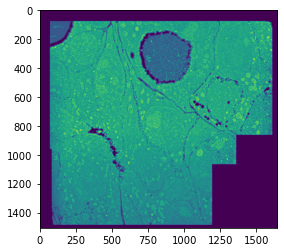

In [6]:
show_one_image(image)

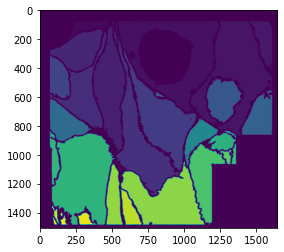

In [7]:
show_one_image(mask)

In [8]:
image = imageio.imread(list(images_dir.glob("*.tiff"))[5])
mask = imageio.imread(list(labels_dir.glob("*.tiff"))[5])

In [10]:
tile_layout, ind_min, ind_max = split_with_overlap(image, tile_size=(1024, 1024), overlap=0.1)

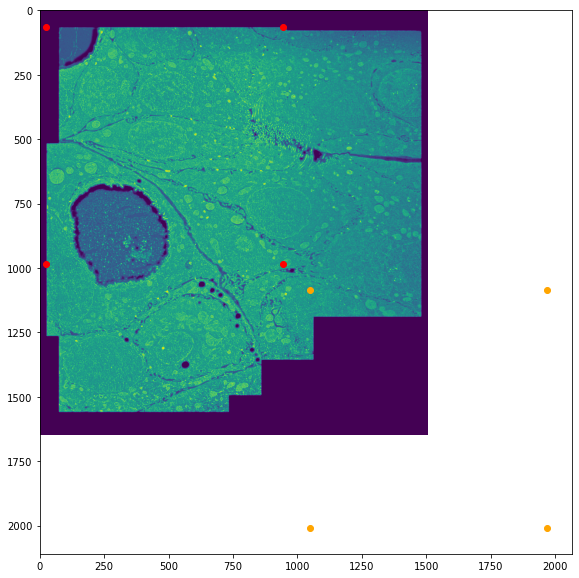

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image.T)
plt.scatter(ind_min[0, :], ind_min[1, :], c="r")
plt.scatter(ind_max[0, :], ind_max[1, :], c="orange")

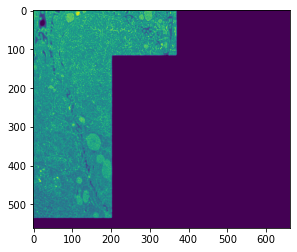

In [12]:
n = -1
plt.imshow(image[ind_min[:, n][0]:ind_max[:, n][0], ind_min[:, n][1]:ind_max[:, n][1], ...])

Load the dataset and visualize it with a simple function:

In [18]:
tile_size = (512, 512)

In [19]:
train_images_dir = data_dir / "F107_bin2_619-639_frames" / "train"
train_labels_dir = data_dir / "corrected_labels" / "train"
train_data = EMDataset(train_images_dir, train_labels_dir, tile_size=tile_size)
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)

In [20]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))    # take a random sample
    img, mask = dataset[idx]                    # get the image and the nuclei masks
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img[0])                     # show the image
    axarr[1].imshow(mask[0])                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print('Image size is %s' % {img[0].shape})
    plt.show()

Image size is {torch.Size([512, 512])}


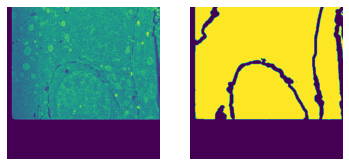

In [21]:
show_random_dataset_image(train_data)

And the same for the validation data:

In [22]:
test_images_dir = data_dir / "F107_bin2_619-639_frames" / "test"
test_labels_dir = data_dir / "corrected_labels" / "test"
test_data = EMDataset(test_images_dir, test_labels_dir, tile_size=tile_size)
val_loader = DataLoader(test_data, batch_size=1)

Image size is {torch.Size([512, 512])}


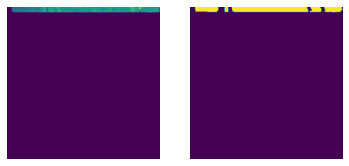

In [23]:
show_random_dataset_image(test_data)

## Run tensorboard

In [33]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6008 (pid 144186), started 4 days, 3:15:53 ago. (Use '!kill 144186' to kill it.)

## Load model and predict for all images

In [78]:
model_path = "models/model_01.pt"

model_loaded = UNet(1, 4, final_activation=nn.Sigmoid())
checkpoint = torch.load(model_path)
model_loaded.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [80]:
tile = test_data[0]

In [85]:
tile[0].shape

torch.Size([1, 512, 512])

In [87]:
model_loaded.eval()

prediction = model_loaded(tile[0][None, :, :, :])

0
1
2
3


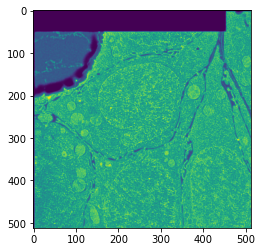

In [90]:
plt.imshow(tile[0][0, :, :])

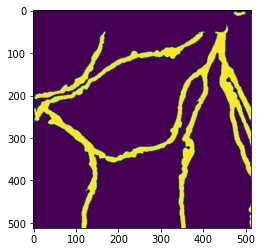

In [95]:
plt.imshow(tile[1][2, :, :])

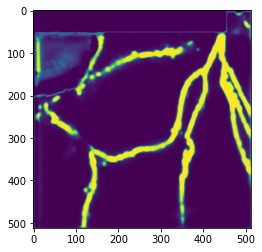

In [101]:
plt.imshow(prediction.detach()[0, 2, :, :])

In [50]:
net

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (base): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
tb_logg

## Additional Exercises 

1. Implement and compare at least 2 of the following architecture variants of the U-Net:
    * use [Dropout](https://pytorch.org/docs/stable/nn.html#dropout-layers) in the decoder path
    * use [BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) to normalize layer inputs
    * use [GroupNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.GroupNorm) to normalize convolutional group inputs
    * use [ELU-Activations](https://pytorch.org/docs/stable/nn.html#torch.nn.ELU) instead of ReLU-Activations

2. Use the Dice coefficient as loss function. Before we only used it for validation, but it is differentiable and can thus also be used as loss. Compare to the results from exercise 2. 
Hint: The optimizer we use finds minima of the loss, but the minimal value for the Dice coefficient corresponds to a bad segmentation. How do we need to change the Dice coefficient to use it as loss nonetheless?

3. Add one more layer to the U-net model (currently it has 4). Compare the results.

## Advanced Exercises

1. Visualize the graph (model) that we are using with TensorBoard
2. Write your own data transform (e.g., RandomRotate)